In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *
import pickle
import gc
from tqdm import tqdm
from IPython.display import display_html
from typing import Iterable
import warnings
from sklearn.exceptions import * 

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Data

In [3]:
data_prior = pd.read_csv('./data/00-22/all_seasons_cumu_net_total_prior.csv').drop(columns='Unnamed: 0')
data_true = pd.read_csv('./data/00-22/all_seasons_gamelog_facts.csv').drop(columns='Unnamed: 0')
index = data_prior[data_prior['game_season'] > 10].dropna().sample(10000,random_state=1).index
# index = data_prior[data_prior['game_season'] > 10].dropna().index
columns = data_prior.columns[data_prior.columns.str.endswith('net')]

X = data_prior.loc[index,columns]
y = data_true.loc[index,'game_result']
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=data_prior.loc[index,'month'],random_state=1)

In [4]:
X

,game_result_net,pts_net,opp_pts_net,fg_net,fga_net,fg_pct_net,fg3_net,fg3a_net,fg3_pct_net,ft_net,...,efg_pct_net,tov_pct_net,orb_pct_net,ft_rate_net,opp_efg_pct_net,opp_tov_pct_net,drb_pct_net,opp_ft_rate_net,net_pts_net,net_rtg_net
11285,0.030769,3.661538,1.492308,1.738462,3.307692,0.004123,2.753846,6.169231,0.019231,-2.569231,...,0.018646,-2.349231,-4.401538,-0.040400,0.011338,-0.470769,1.756923,-0.063062,2.169231,2.563077
40130,-0.039216,3.705882,4.921569,0.529412,1.705882,-0.003451,1.745098,2.352941,0.070980,0.901961,...,0.005784,-0.700000,3.254902,0.006000,0.013510,-1.149020,-3.313725,0.022000,-1.215686,-1.354902
42805,-0.112072,-2.234775,2.155315,-0.418018,1.288108,-0.011710,1.046306,1.471171,0.026527,-2.445045,...,-0.006108,1.320919,1.519063,-0.035483,0.012416,-0.039874,1.023297,0.020154,-4.390090,-4.592865
12090,0.479640,6.736269,-5.585701,1.241004,0.996686,0.010694,0.750000,1.802083,0.015102,3.504261,...,0.015204,-1.881250,4.502036,0.039678,-0.035384,-1.673106,2.087169,-0.002315,12.321970,13.546780
54427,0.131670,7.348579,3.966736,1.765766,3.580042,-0.000622,2.115038,3.637561,0.054407,1.702010,...,0.010295,-2.682536,-5.212405,0.012788,0.013784,0.994387,-4.293001,-0.010658,3.381843,3.266528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51460,0.343750,8.812500,-3.500000,2.531250,4.312500,0.007094,4.000000,5.968750,0.040344,-0.250000,...,0.026250,-1.668750,7.309375,-0.014156,-0.034562,-2.825000,0.968750,-0.023031,12.312500,12.490625
40738,-0.240260,-5.465368,0.138528,-5.071429,-5.792208,-0.031455,3.965368,10.917749,0.029002,0.712121,...,-0.004855,2.368398,-4.180519,0.023253,-0.030019,-0.857792,-3.537662,0.056831,-5.603896,-6.050000
39254,0.009519,2.409572,3.093337,-0.910894,1.000000,-0.019380,4.664463,11.771285,0.019032,-0.433104,...,0.009855,-0.190349,6.137758,-0.010226,0.033569,-1.271840,3.124564,-0.032308,-0.683765,-0.836753
34428,-0.172414,-16.051724,-7.982759,-7.672414,-9.965517,-0.037431,-6.068966,-14.448276,-0.036638,5.362069,...,-0.069259,0.486207,4.305172,0.092483,0.012155,1.375862,0.700000,0.046845,-8.068966,-8.594828


In [5]:
y

11285    1
40130    0
42805    0
12090    1
54427    1
        ..
51460    0
40738    0
39254    0
34428    0
49562    1
Name: game_result, Length: 10000, dtype: int64

In [187]:
aslist = lambda x: x if isinstance(x,Iterable) and not isinstance(x,str) else [x]

class Trainer:
    def __init__(self,models=None) -> None:
        self.models = models if models is not None else [RandomForestClassifier(),RidgeClassifier(),SVC(),LogisticRegression()]

    def fit(self,X,y):
        models = tqdm(self.models)
        for model in models:
            models.set_description(desc=f"{model.__class__.__name__}")
            model.fit(X,y)
        return self

    def predict(self,X):
        self.predictions = []
        for model in self.models:
            self.predictions.append(model.predict(X))
        self.predictions = np.array(self.predictions)
        return self.predictions 
    
    def score(self,X,y,scorers=f1_score,*args):
        self.scores = {}
        self.predict(X)
        for i,scorer in enumerate(aslist(scorers)):
            if scorer.__name__ not in self.scores.keys():
                self.scores[scorer.__name__] = []
            if len(args) == len(aslist(scorers)):
                kwargs = args[i]
            else:
                kwargs = {}
            for y_pred in self.predictions:
                self.scores[scorer.__name__].append(scorer(y,y_pred,**kwargs))
        return self.scores

    def accuracy_score(self,y_true,y_preds,axis=0):
        y_correct = y_preds == np.tile(y_true,(y_preds.shape[0],1))
        return y_correct.mean(axis)
    
    def mae_score(self,y_true,y_preds,axis=0):
        y_error = y_preds - np.tile(y_true,(y_preds.shape[0],1))
        return np.abs(y_error).mean(axis)
    
trainer = Trainer(
    models = [RandomForestClassifier(),
              RidgeClassifier(),
              SVC(),
              LogisticRegression()]
)
trainer.fit(X_train,y_train).score(X_test,y_test,[f1_score])
# classification_acc = trainer.accuracy_score(y_test,trainer.predictions,axis=0)
# pd.value_counts(classification_acc).sort_index()

LogisticRegression: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]    


0.00     628
0.25     146
0.50     113
0.75     170
1.00    1443
Name: count, dtype: int64

Detect Outlier Cases

In [236]:
class OutlierDectection(Trainer):
    def __init__(self, models, classification_model = Trainer(), threshold=0.5, kfold = KFold(n_splits=3), is_classification = True) -> None:
        super().__init__(models)
        self.threshold = threshold
        self.kfold = kfold
        self.classification_model = classification_model
        self.is_classification = is_classification

    def detect_outliers(self, X, y):
        self.model_predictions = None
        for train_index, val_index in self.kfold.split(X):
            X_train, y_train = np.array(X)[train_index], np.array(y)[train_index]
            X_val, y_val = np.array(X)[val_index], np.array(y)[val_index]
            super().fit(X_train, y_train)
            if self.model_predictions is None:
                self.model_predictions = super().predict(X_val)
            else:
                self.model_predictions = np.concatenate([self.model_predictions,super().predict(X_val)],axis=1)
        if self.is_classification:
            self.predictions_accuracy = self.accuracy_score(y,self.model_predictions)
            self.outliers = (self.predictions_accuracy < self.threshold).astype(int)
        else:
            self.predictions_error = self.mae_score(y,self.model_predictions)
            self.outliers = (self.predictions_error > self.threshold).astype(int)
        return self.outliers
    
    def fit(self,X,y):
        self.detect_outliers(X,y)
        self.classification_model.fit(X,self.outliers)
        return self

    def predict(self, X):
        self.classification_model.predict(X)
        self.predictions = (self.classification_model.predictions.mean(0) > 0).astype(int)
        return self.predictions

outlier = OutlierDectection(
    models = [RandomForestClassifier(),
              RidgeClassifier(),
              SVC(),
              LogisticRegression()],
    threshold = 1,
    is_classification = True
)

In [237]:
outlier.fit(X_train,y_train).predict(X_test)
print(pd.value_counts(outlier.outliers).sort_index())
print(pd.value_counts(outlier.predictions).sort_index())

LogisticRegression: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]    


0    4222
1    3278
Name: count, dtype: int64
0    1164
1    1336
Name: count, dtype: int64


In [238]:
trainer = Trainer(
    models = [RandomForestClassifier(),
              RidgeClassifier(),
              SVC(),
              LogisticRegression()]
)

trainer.fit(X_train,y_train).score(X_test,y_test,[accuracy_score])

LogisticRegression: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]    


{'accuracy_score': [0.6592, 0.6696, 0.6608, 0.6716]}

In [239]:
trainer.score(X_test[outlier.predictions == 1],y_test[outlier.predictions == 1],[accuracy_score])

{'accuracy_score': [0.5988023952095808,
  0.6100299401197605,
  0.5950598802395209,
  0.6137724550898204]}

In [240]:
trainer.score(X_test[outlier.predictions == 0],y_test[outlier.predictions == 0],[accuracy_score])

{'accuracy_score': [0.7285223367697594,
  0.7379725085910653,
  0.7362542955326461,
  0.7379725085910653]}

Regression

In [215]:
data_prior = pd.read_csv('./data/00-22/all_seasons_cumu_net_total_prior.csv').drop(columns='Unnamed: 0')
data_true = pd.read_csv('./data/00-22/all_seasons_gamelog_facts.csv').drop(columns='Unnamed: 0')
index = data_prior[data_prior['game_season'] > 10].dropna().sample(10000,random_state=1).index
# index = data_prior[data_prior['game_season'] > 10].dropna().index
columns = data_prior.columns[data_prior.columns.str.endswith('net')]

X = data_prior.loc[index,columns]
y = data_true.loc[index,'net_pts']
# clamp y between [-20,20]
y[y < -20] = -20
y[y > 20] = 20
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=data_prior.loc[index,'month'],random_state=1)

In [216]:
outlier = OutlierDectection(
    models = [RandomForestRegressor(),
              Ridge(),
              SVR(),
              LinearRegression()],
    threshold = 10,
    is_classification=False
)

outlier.fit(X_train,y_train).predict(X_test)
print(pd.value_counts(outlier.outliers).sort_index())
print(pd.value_counts(outlier.predictions).sort_index())

LogisticRegression: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]    


0    4466
1    3034
Name: count, dtype: int64
0    2187
1     313
Name: count, dtype: int64


In [217]:
np.median(outlier.predictions_error)

8.182197230392264

In [218]:
trainer = Trainer(
    models = [RandomForestRegressor(),
              Ridge(),
              SVR(),
              LinearRegression()]
)

trainer.fit(X_train,y_train)
print(trainer.score(X_test,y_test,[r2_score,mean_absolute_error]))
print(trainer.score(X_test[outlier.predictions == 1],y_test[outlier.predictions == 1],[r2_score,mean_absolute_error]))  
print(trainer.score(X_test[outlier.predictions == 0],y_test[outlier.predictions == 0],[r2_score,mean_absolute_error]))

LinearRegression: 100%|██████████| 4/4 [00:25<00:00,  6.34s/it]     


{'r2_score': [0.14453487711927904, 0.18209516002545756, 0.16673027282630548, 0.18420438386721505], 'mean_absolute_error': [8.971092, 8.831923199249784, 8.807930922758306, 8.820108039332474]}
{'r2_score': [0.0072010316214873304, 0.10918470047867046, 0.06394246267507697, 0.11431023164433685], 'mean_absolute_error': [9.207987220447286, 8.718308596061618, 8.871092814835796, 8.68175604130981]}
{'r2_score': [0.16115972403985268, 0.19050075491027174, 0.17895004910939138, 0.19222555820422016], 'mean_absolute_error': [8.937187928669413, 8.84818354255015, 8.798891292113472, 8.839908759671339]}


In [225]:
y_train_trf = StandardScaler().fit_transform(y_train.values.reshape(-1,1)).flatten()
y_test_trf = StandardScaler().fit_transform(y_test.values.reshape(-1,1)).flatten()
y_train_trf

array([ 1.67745451,  0.31913676,  0.31913676, ...,  1.67745451,
       -0.6147067 ,  0.74361105])

In [226]:
outlier = OutlierDectection(
    models = [RandomForestRegressor(),
              Ridge(),
              SVR(),
              LinearRegression()],
    threshold = 0.5,
    is_classification=False
)

outlier.fit(X_train,y_train_trf).predict(X_test)
print(pd.value_counts(outlier.outliers).sort_index())
print(pd.value_counts(outlier.predictions).sort_index())

LogisticRegression: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]    


0    2772
1    4728
Name: count, dtype: int64
1    2500
Name: count, dtype: int64


In [228]:
trainer = Trainer(
    models = [RandomForestRegressor(),
              Ridge(),
              SVR(),
              LinearRegression()]
)

trainer.fit(X_train,y_train_trf)
print(trainer.score(X_test,y_test_trf,[r2_score,mean_absolute_error]))
print(trainer.score(X_test[outlier.predictions == 1],y_test_trf[outlier.predictions == 1],[r2_score,mean_absolute_error]))  
# print(trainer.score(X_test[outlier.predictions == 0],y_test[outlier.predictions == 0],[r2_score,mean_absolute_error]))

LinearRegression: 100%|██████████| 4/4 [00:25<00:00,  6.36s/it]     


{'r2_score': [0.15398809874807373, 0.18339591794511367, 0.12352823096493881, 0.18551920925667875], 'mean_absolute_error': [0.7599404288077121, 0.7521651885117197, 0.7697820282330942, 0.7512925815227507]}
{'r2_score': [0.15398809874807373, 0.18339591794511367, 0.12352823096493881, 0.18551920925667875], 'mean_absolute_error': [0.7599404288077121, 0.7521651885117197, 0.7697820282330942, 0.7512925815227507]}


<Axes: ylabel='Frequency'>

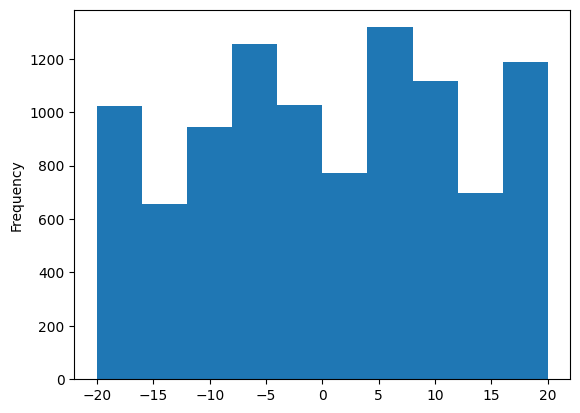

In [230]:
y.plot.hist()